In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from darts.models import RNNModel
from darts.metrics import mape, mae, rmse
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries    
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [2]:
df = pd.read_csv("./data/amf-performance.csv")
df['datetime'] = pd.to_datetime(df['time'], unit='s') # resample function needs a datetime column
df = df.drop(['time', 'lat75', 'lat80', 'lat90', 'lat95', 'lat98', 'lat99', 'lat100'], axis=1)

frequency = '1h'

# additional features
df['day'] = pd.DatetimeIndex(df['datetime']).day
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

# Remove from ram_limit 'M' and convert the column to integer
df['ram_limit'] = df['ram_limit'].str.replace('M', '').astype(int)

df_max = df.resample(frequency, on='datetime').max()
df_max

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-10 14:00:00,2048.0,2.0,1.130758e+09,1.276808,500.0,60398090.0,60414274.0,10.0,14.0
2021-11-10 15:00:00,2048.0,2.0,1.559351e+09,0.996645,460.0,93936583.0,94259814.0,10.0,15.0
2021-11-10 16:00:00,2048.0,2.0,1.494233e+09,0.983066,480.0,95931083.0,96020918.0,10.0,16.0
2021-11-10 17:00:00,2048.0,2.0,1.600532e+09,0.983279,480.0,97132575.0,97360300.0,10.0,17.0
2021-11-10 18:00:00,2048.0,2.0,1.010856e+09,0.999460,440.0,97207925.0,97417298.0,10.0,18.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


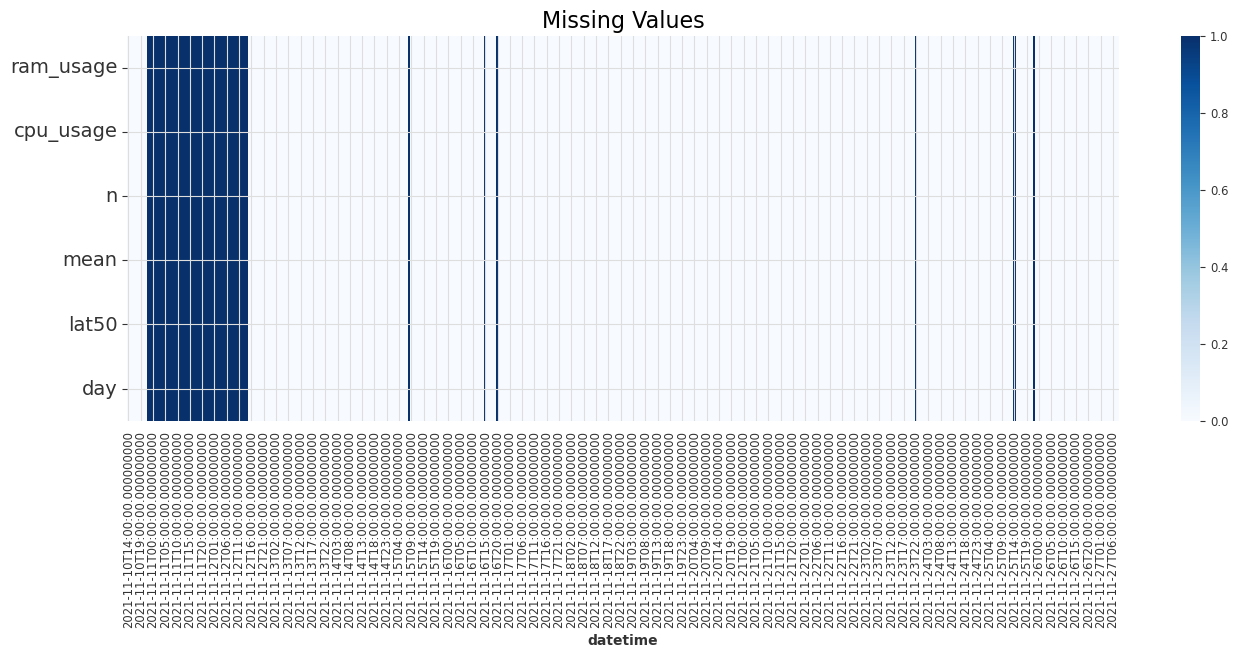

In [3]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df_max.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed


for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
plt.show()

Remove the big portion of missing values

In [4]:
# Set the filter condition based on the desired date and time
df_max_reset = df_max.reset_index()
df_max_reset['datetime'] = pd.to_datetime(df_max_reset['datetime'])
filter_condition = df_max_reset['datetime'] > '2021-11-12 14:00:00'

# Apply the filter to get the subset of the DataFrame
filtered_df = df_max_reset[filter_condition].set_index('datetime')

Plot filtered datafarame

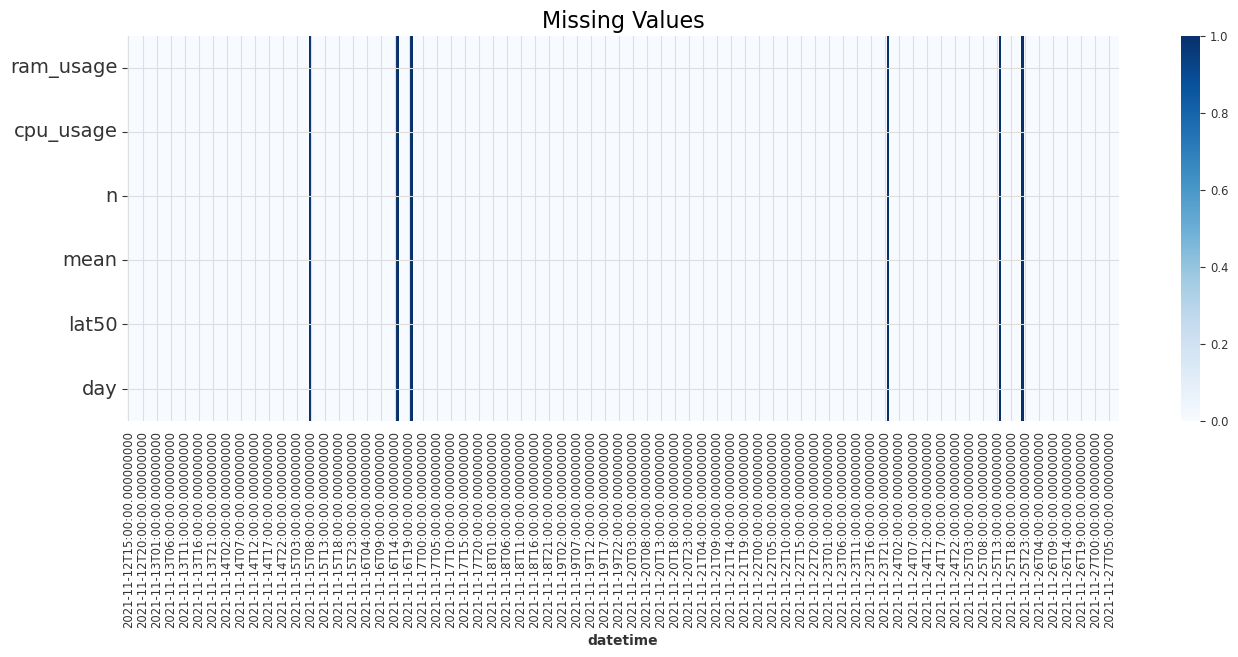

In [5]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(filtered_df.iloc[:,2:-1].T.isna(), cmap='Blues') #drop useless columns
ax.set_title('Missing Values', fontsize=16)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set the rotation angle as needed


for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
plt.show()

Interpolate in order to fill the null values in the df

In [6]:
interpolated_df = filtered_df.interpolate()
interpolated_df.isna().sum()

ram_limit    0
cpu_limit    0
ram_usage    0
cpu_usage    0
n            0
mean         0
lat50        0
day          0
hour         0
dtype: int64

In [7]:
interpolated_df

,ram_limit,cpu_limit,ram_usage,cpu_usage,n,mean,lat50,day,hour
datetime,,,,,,,,,
2021-11-12 15:00:00,4096.0,4.0,1.203683e+09,1.358302,520.0,67451009.0,67428077.0,12.0,15.0
2021-11-12 16:00:00,3584.0,4.0,1.870483e+09,1.385498,520.0,68222008.0,68162522.0,12.0,16.0
2021-11-12 17:00:00,3072.0,4.0,1.847726e+09,1.382358,550.0,77777013.0,77747786.0,12.0,17.0
2021-11-12 18:00:00,2304.0,4.0,1.854063e+09,1.358083,530.0,70557306.0,70546856.0,12.0,18.0
2021-11-12 19:00:00,1280.0,4.0,1.766617e+09,1.307712,520.0,68996878.0,68965997.0,12.0,19.0
...,...,...,...,...,...,...,...,...,...
2021-11-27 04:00:00,1280.0,2.0,1.753735e+09,1.323356,550.0,98065398.0,98048590.0,27.0,4.0
2021-11-27 05:00:00,4096.0,2.0,1.023115e+09,1.257932,550.0,98199627.0,98221357.0,27.0,5.0
2021-11-27 06:00:00,3840.0,1.5,1.836081e+09,1.324840,550.0,96423698.0,96467143.0,27.0,6.0


# LSTM multivariate forecasting
Forecast multiple related time series simultaneously. Related time series here are: 'cpu_usage', 'ram_usage', 'cpu_limit', 'ram_limit'

In [8]:
# define train and test size
train_size = int(0.7 * len(interpolated_df))
test_size = len(interpolated_df) - train_size

split_point = interpolated_df.iloc[train_size].name
split_point

Timestamp('2021-11-22 22:00:00')

define TimeSeries components and train a LSTM with all target components at once

In [9]:
series = TimeSeries.from_dataframe(interpolated_df.reset_index(), 'datetime', ['cpu_usage', 'ram_usage', 'cpu_limit', 'ram_limit'])

# train test split
train, test = series.split_after(split_point)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(test)
series_transformed = transformer.transform(series)

# eventually use in addition to covariates (see below)


In [12]:
# define early stopping parameters
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.0005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper], "log_every_n_steps": 5}

# build model
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=8,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM_forecast_all",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=5,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)

# train model
my_model.fit(
    train_transformed,
    val_series=val_transformed,
    verbose=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.1 K 
4 | V             | Linear           | 84    
---------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=20, batch_size=8, n_epochs=300, optimizer_kwargs={'lr': 0.001}, model_name=LSTM_forecast_all, log_tensorboard=True, random_state=42, input_chunk_length=5, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000001D450F89ED0>], 'log_every_n_steps': 5})

In [13]:
def eval_model(model):
    pred_series = model.predict(n=test_size - 1)
    
    num_components = series_transformed.n_components  # Get the number of components
    fig, axs = plt.subplots(num_components, 1, figsize=(25, 5 * num_components))  # Create subplots

    for i, component in enumerate(series_transformed.columns):
        ax = axs[i] if num_components > 1 else axs  # Handle single subplot case
        series_transformed[component].plot(ax=ax, label="actual")
        pred_series[component].plot(ax=ax, label="forecast")

        rmse_score = rmse(pred_series[component], val_transformed[component])
        mae_score = mae(pred_series[component], val_transformed[component])
        mape_score = mape(pred_series[component], val_transformed[component])
        
        ax.set_title(f"Component: {component}, RMSE: {rmse_score:.2f}%, MAE: {mae_score:.2f}%, MAPE: {mape_score:.2f}%")
        ax.legend()

    plt.tight_layout()
    plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

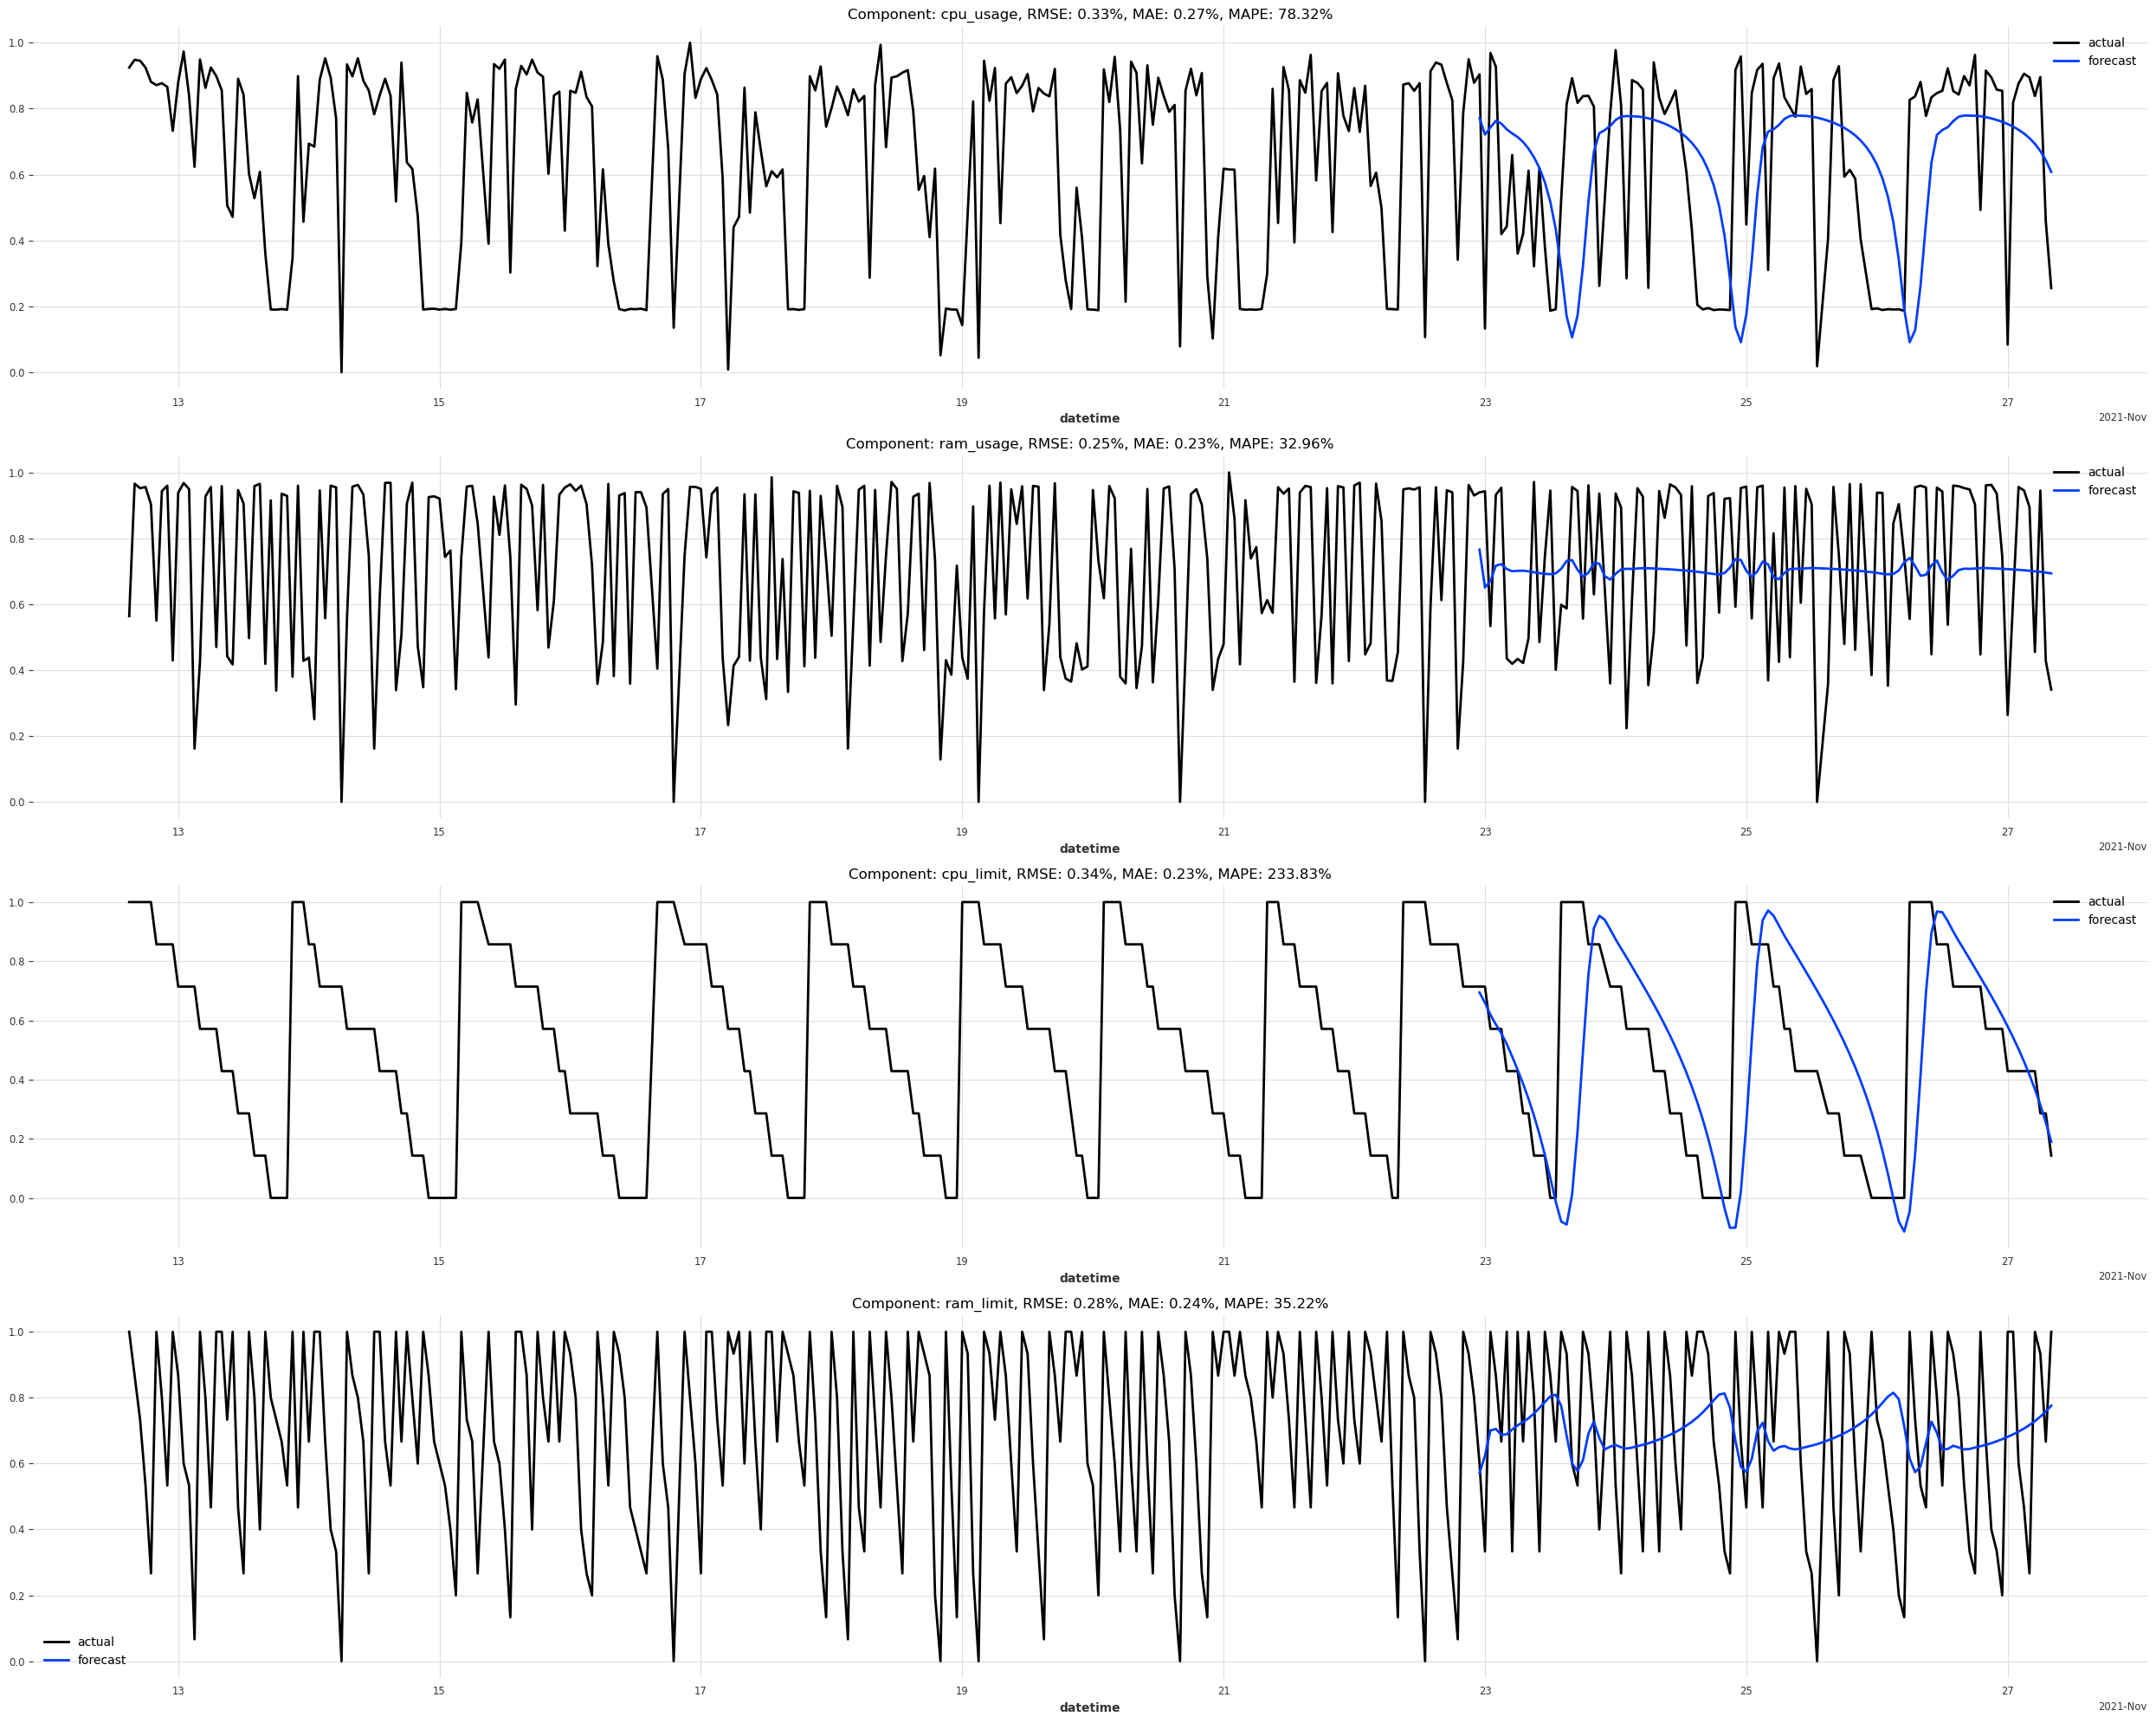

In [14]:
best_model = RNNModel.load_from_checkpoint(model_name="LSTM_forecast_all", best=True)
eval_model(best_model)

In [15]:
predictions = best_model.predict(n=1)
predictions

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

<TimeSeries (DataArray) (datetime: 1, component: 4, sample: 1)> Size: 32B
array([[[0.77119834],
        [0.76569192],
        [0.69436069],
        [0.57110302]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 8B 2021-11-22T23:00:00
  * component  (component) object 32B 'cpu_usage' 'ram_usage' ... 'ram_limit'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [16]:
predictions_df = predictions.pd_dataframe()

In [123]:
# use this to save predictions in a json file
#json = predictions_df.to_json('./../forecast_output_LSTM_multivariate.json')

### Forecast CPU usage using covariates
Training with covariates means using additional information (covariates) that may help improve the accuracy of the forecast for the main time series of interest. These covariates are external variables that are not being forecasted themselves but are used to inform the forecast of the primary series. 

In this example covariates are: 'ram_limit', 'cpu_limit', 'ram_usage', 'n', 'mean', 'lat50', 'day', 'hour'

N.B. this is an example of how to use covariates. You can't use covariates this way in a real world scenario because future ram_limit, ram_usage, [...], are not known in advance and must be forecasted first.

In [17]:
# create covariates
covariates = interpolated_df.drop(columns=['cpu_usage'])
covariates = TimeSeries.from_dataframe(covariates.reset_index(), 'datetime')
covariates

<TimeSeries (DataArray) (datetime: 354, component: 8, sample: 1)> Size: 23kB
array([[[4.09600000e+03],
        [4.00000000e+00],
        [1.20368333e+09],
        ...,
        [6.74280770e+07],
        [1.20000000e+01],
        [1.50000000e+01]],

       [[3.58400000e+03],
        [4.00000000e+00],
        [1.87048346e+09],
        ...,
        [6.81625220e+07],
        [1.20000000e+01],
        [1.60000000e+01]],

       [[3.07200000e+03],
        [4.00000000e+00],
        [1.84772608e+09],
        ...,
...
        ...,
        [9.64671430e+07],
        [2.70000000e+01],
        [6.00000000e+00]],

       [[2.81600000e+03],
        [1.50000000e+00],
        [9.78534400e+08],
        ...,
        [1.57881690e+07],
        [2.70000000e+01],
        [7.00000000e+00]],

       [[4.09600000e+03],
        [1.00000000e+00],
        [8.33396736e+08],
        ...,
        [4.41461200e+06],
        [2.70000000e+01],
        [8.00000000e+00]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 3kB 2021-11-12T15:00:00 ... 2021-11-...
  * component  (component) object 64B 'ram_limit' 'cpu_limit' ... 'day' 'hour'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [18]:
covariates.components

Index(['ram_limit', 'cpu_limit', 'ram_usage', 'n', 'mean', 'lat50', 'day',
       'hour'],
      dtype='object', name='component')

In [20]:
# define target series to forecast
series = TimeSeries.from_dataframe(interpolated_df.reset_index(), 'datetime', ['cpu_usage'])

# train test split
train, test = series.split_after(split_point)
cov_train, cov_test = covariates.split_after(split_point)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(test)
series_transformed = transformer.transform(series)

transformer_cov = Scaler()
cov_train = transformer_cov.fit_transform(cov_train)
cov_test = transformer_cov.transform(cov_test)
covariates_transformed = transformer_cov.transform(covariates)


In [21]:
# define early stopping parameters
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.0005,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper], "log_every_n_steps": 5}

# build model
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=8,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM_cpu_usage",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=5,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)

# train model
my_model.fit(
    train_transformed,
    future_covariates=covariates_transformed,
    val_series=val_transformed,
    val_future_covariates=covariates_transformed,
    verbose=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.5 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=20, batch_size=8, n_epochs=300, optimizer_kwargs={'lr': 0.001}, model_name=LSTM_cpu_usage, log_tensorboard=True, random_state=42, input_chunk_length=5, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000001D454C63AD0>], 'log_every_n_steps': 5})

In [22]:
def eval_model(model):
    pred_series = model.predict(n=test_size - 1, future_covariates=covariates_transformed)
    rmse_score = rmse(pred_series, val_transformed)
    mae_score = mae(pred_series, val_transformed)
    mape_score = mape(pred_series, val_transformed)
    # plot
    plt.figure(figsize=(25, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(f"CPU usage: RMSE: {rmse_score:.2f}%, MAE: {mae_score:.2f}%, MAPE: {mape_score:.2f}%")
    plt.legend()
    plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

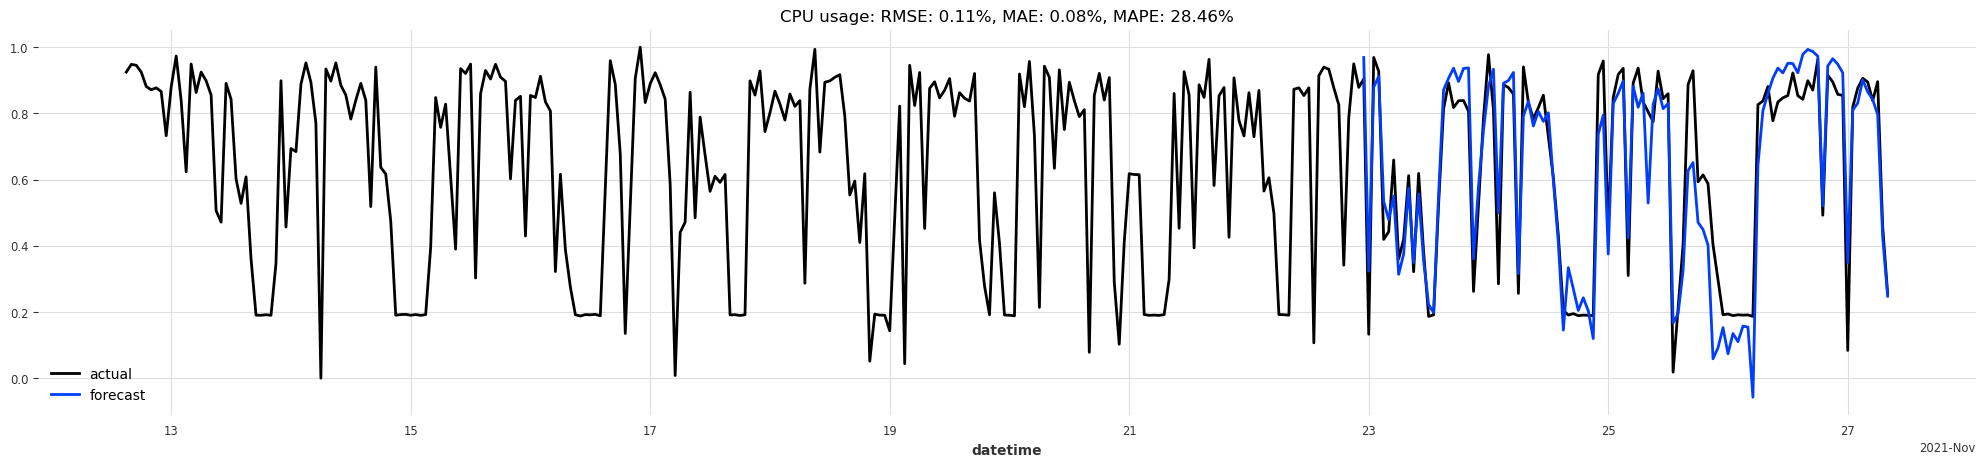

In [23]:
best_model = RNNModel.load_from_checkpoint(model_name="LSTM_cpu_usage", best=True)
eval_model(best_model)

In [25]:
predictions = best_model.predict(n=1, future_covariates=covariates_transformed)
predictions

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

<TimeSeries (DataArray) (datetime: 1, component: 1, sample: 1)> Size: 8B
array([[[0.96887241]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 8B 2021-11-22T23:00:00
  * component  (component) object 8B 'cpu_usage'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None